# Pulse Wave Analysis
Extract features from PPG pulse waves

---
## Specify an ICU stay and segment

<div class="alert alert-block alert-warning"> <b>Resource:</b> These steps are taken from the <a href="https://wfdb.io/mimic_wfdb_tutorials/tutorial/notebooks/data-visualisation.html">Data Visualisation</a> tutorial. </div>

- Specify the required Python packages

In [1]:
import sys
import wfdb

- Get a list of ICU stays in the database

In [2]:
database_name = 'mimic3wdb/1.0' # The name of the MIMIC III Waveform Database on Physionet (see URL: https://physionet.org/content/mimic3wdb/1.0/)
icustay_records = wfdb.get_record_list(database_name)
print("There are {} ICU stays in the database".format(len(icustay_records)))

There are 67830 ICU stays in the database


- Specify an ICU stay

In [3]:
icustay_no = 10 # specify the first record (noting that in Python the first index is 0)
icustay_record = icustay_records[icustay_no]
icustay_record_dir = database_name + '/' + icustay_record
icustay_record_name = icustay_record.split("/")[1]
print("Specified ICU stay: {}".format(icustay_record_name))

Specified ICU stay: 3000125


- Specify a segment of this ICU stay

In [4]:
icustay_files = wfdb.get_record_list(icustay_record_dir)
icustay_segments = [s for s in icustay_files if "_" in s]
icustay_segment_no = 4;
icustay_segment_name = icustay_segments[icustay_segment_no]
print("Specified segment: '{}' within ICU stay '{}'".format(icustay_segment_name, icustay_record_name))

Specified segment: '3000125_0005' within ICU stay '3000125'


---
## Extract data for this segment
<div class="alert alert-block alert-warning"> <b>Resource:</b> These steps are taken from the <a href="https://wfdb.io/mimic_wfdb_tutorials/tutorial/notebooks/data-visualisation.html">Data Visualisation</a> tutorial. </div>

- Specify the timings of the data to be extracted

In [5]:
start_seconds = 60 # time since the start of the segment at which to begin extracting data
no_seconds_to_load = 5

- Find out the sampling frequency of the waveform data

In [6]:
segment_metadata = wfdb.rdheader(record_name=icustay_segment_name, pn_dir=icustay_record_dir)
fs = segment_metadata.fs

- Extract the specified data

In [7]:
sampfrom = fs*start_seconds
sampto = fs*(start_seconds+no_seconds_to_load)
segment_data = wfdb.rdrecord(record_name=icustay_segment_name, sampfrom=sampfrom, sampto=sampto, pn_dir=icustay_record_dir) 
print("{} seconds of data extracted from: {}".format(no_seconds_to_load, icustay_segment_name))

5 seconds of data extracted from: 3000125_0005


---
## Extract the PPG signal
<div class="alert alert-block alert-warning"> <b>Resource:</b> This step is taken from the <a href="https://wfdb.io/mimic_wfdb_tutorials/tutorial/notebooks/differentiation.html">Differentiation</a> tutorial. </div>

- Extract the PPG signal from the segment data

In [8]:
ppg = segment_data.p_signal[:,2]

---
## Filter the PPG signal
<div class="alert alert-block alert-warning"> <b>Resource:</b> This step is taken from the <a href="https://wfdb.io/mimic_wfdb_tutorials/tutorial/notebooks/differentiation.html">Differentiation</a> tutorial. </div>

- Import the [SciPy signal processing package](https://docs.scipy.org/doc/scipy/tutorial/signal.html), which contains functions for filtering and differentiating.

In [9]:
import scipy.signal as sp

- Filter the PPG signal in preparation for differentiation using a Butterworth filter provided by the [butter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) function.

In [10]:
sos_ppg = sp.butter(10, [0.7, 10], btype = 'bp', analog = False, output = 'sos', fs = segment_data.fs)
w, h = sp.sosfreqz(sos_ppg, 2000, fs = fs)
ppg_filt = sp.sosfiltfilt(sos_ppg, ppg)

- We will use the filtered signal instead of the original PPG from now on.

---
## Setup PPG beat detection
<div class="alert alert-block alert-warning"> <b>Resource:</b> This step is taken from the <a href="https://wfdb.io/mimic_wfdb_tutorials/tutorial/notebooks/beat-detection.html">Beat detection</a> tutorial. </div>
<div class="alert alert-block alert-warning"> <b>Tip:</b> Several scripts and packages are used during beat detection. This section sets up the process. To skip to the actual beat detection, click <a href="#Detect-beats-using-a-range-of-beat-detection-algorithms">here</a>. </div>


- Specify the Python packages required for beat detection

In [11]:
import numpy as np

- Define the functions required to detect beats in the PPG signal

In [12]:
def pulse_detect(x,fs,w,alg):
    """
    Description: Pulse detection and correction from pulsatile signals
    Inputs:  x, array with pulsatile signal [user defined units]
             fs, sampling rate of signal [Hz]
             w, window length for analysis [s]
             alg, string with the name of the algorithm to apply ['heartpy','d2max','upslopes','delineator']
    Outputs: ibis, location of cardiac cycles as detected by the selected algorithm [number of samples]
    
    Algorithms:       1: HeartPy (van Gent et al, 2019, DOI: 10.1016/j.trf.2019.09.015)
                      2: 2nd derivative maxima (Elgendi et al, 2013, DOI: 10.1371/journal.pone.0076585)
                      3: Systolic upslopes (Arguello Prada and Serna Maldonado, 2018, 
                         DOI: 10.1080/03091902.2019.1572237)
                      4: Delineator (Li et al, 2010, DOI: 10.1109/TBME.2005.855725)
    Fiducial points:  1: Systolic peak (pks)
                      2: Onset, as the minimum before the systolic peak (ons)
                      3: Onset, using the tangent intersection method (ti) 
                      4: Diastolic peak (dpk)
                      5: Maximum slope (m1d)
                      6: a point from second derivative PPG (a2d)
                      7: b point from second derivative PPG (b2d)
                      8: c point from second derivative PPG (c2d)
                      9: d point from second derivative PPG (d2d)
                      10: e point from second derivative PPG (e2d)
                      11: p1 from the third derivative PPG (p1)    
                      12: p2 from the third derivative PPG (p2)
    
    Libraries: NumPy (as np), SciPy (Signal, as sp), Matplotlib (PyPlot, as plt)
    
    Version: 1.0 - June 2022
    
    Developed by: Elisa Mejía-Mejía
                   City, University of London
    
    """
    
    # Check selected algorithm
    pos_alg = ['heartpy','d2max','upslopes','delineator']
    if not(alg in pos_alg):
        print('Unknown algorithm determined. Using D2max as default')
        alg = 'd2max'
    
    # Pre-processing of signal
    x_d = sp.detrend(x)
    sos = sp.butter(10, [0.5, 10], btype = 'bp', analog = False, output = 'sos', fs = fs)
    x_f = sp.sosfiltfilt(sos, x_d)
    
    # Peak detection in windows of length w
    n_int = np.floor(len(x_f)/(w*fs))
    for i in range(int(n_int)):
        start = i*fs*w
        stop = (i + 1)*fs*w - 1
        #print('Start: ' + str(start) + ', stop: ' + str(stop))
        aux = x_f[range(start,stop)]
        if alg == 'heartpy':
            locs = heartpy(aux,fs,40,180,5)
        elif alg == 'd2max':
            locs = d2max(aux,fs)
        elif alg == 'upslopes':
            locs = upslopes(aux)
        elif alg == 'delineator':
            locs = delineator(aux,fs)       
        locs = locs + start
        if i == 0:
            ibis = locs
        else:
            ibis = np.append(ibis,locs)
    if n_int*fs*w != len(x_f):
        start = stop + 1
        stop = len(x_f)
        aux = x_f[range(start,stop)]
        if len(aux) > 20:
            if alg == 'heartpy':
                locs = heartpy(aux,fs,40,180,5)
            elif alg == 'd2max':
                locs = d2max(aux,fs)
            elif alg == 'upslopes':
                locs = upslopes(aux)
            elif alg == 'delineator':
                locs = delineator(aux,fs)          
            locs = locs + start
            ibis = np.append(ibis,locs)
    ind, = np.where(ibis <= len(x_f))
    ibis = ibis[ind]
        
    ibis = peak_correction(x,ibis,fs,20,5,[0.5, 1.5])
    
    #fig = plt.figure()
    #plt.plot(x)
    #plt.plot(x_d)
    #plt.plot(x_f)
    #plt.scatter(ibis,x_f[ibis],marker = 'o',color = 'red')
    #plt.scatter(ibis,x[ibis],marker = 'o',color = 'red')
    
    return ibis

In [13]:
def peak_correction(x,locs,fs,t,stride,th_len):
    """
    Correction of peaks detected from pulsatile signals
    
    Inputs:   x, pulsatile signal [user defined units]
              locs, location of the detected interbeat intervals [number of samples]
              fs, sampling rate [Hz]
              t, duration of intervals for the correction [s]
              stride, stride between consecutive intervals for the correction [s]
              th_len, array with the percentage of lower and higher thresholds for comparing the duration of IBIs 
              [proportions] 
    Outputs:  ibis, array with the corrected points related to the start of the inter-beat intervals [number of samples]
 
    Developed by:  Elisa Mejía Mejía
                   City, University of London
    Version:       1.0 -   June, 2022

    """
    
    #fig = plt.figure()
    #plt.plot(x)
    #plt.scatter(locs,x[locs],marker = 'o',color = 'red', label = 'Original')
    #plt.title('Peak correction')
    
    # Correction of long and short IBIs
    len_window = np.round(t*fs)
    #print('Window length: ' + str(len_window))
    first_i = 0
    second_i = len_window - 1
    while second_i < len(x):
        ind1, = np.where(locs >= first_i)
        ind2, = np.where(locs <= second_i)
        ind = np.intersect1d(ind1, ind2)
        
        win = locs[ind]
        dif = np.diff(win)
        #print('Indices: ' + str(ind) + ', locs: ' + str(locs[ind]) + ', dif: ' + str(dif))
        
        th_dif = np.zeros(2)
        th_dif[0] = th_len[0]*np.median(dif)
        th_dif[1] = th_len[1]*np.median(dif)
        
        th_amp = np.zeros(2)
        th_amp[0] = 0.75*np.median(x[win])
        th_amp[1] = 1.25*np.median(x[win])
        #print('Length thresholds: ' + str(th_dif) + ', amplitude thresholds: ' + str(th_amp))
        
        j = 0
        while j < len(dif):
            if dif[j] <= th_dif[0]:
                if j == 0:
                    opt = np.append(win[j], win[j + 1])
                else:
                    opt = np.append(win[j], win[j + 1]) - win[j - 1]
                print('Optional: ' + str(opt))
                dif_abs = np.abs(opt - np.median(dif))
                min_val = np.min(dif_abs)
                ind_min, = np.where(dif_abs == min_val)
                print('Minimum: ' + str(min_val) + ', index: ' + str(ind_min))
                if ind_min == 0:
                    print('Original window: ' + str(win), end = '')
                    win = np.delete(win, win[j + 1]) 
                    print(', modified window: ' + str(win))
                else:
                    print('Original window: ' + str(win), end = '')
                    win = np.delete(win, win[j]) 
                    print(', modified window: ' + str(win))
                dif = np.diff(win)
            elif dif[j] >= th_dif[1]:
                aux_x = x[win[j]:win[j + 1]]
                locs_pks, _ = sp.find_peaks(aux_x)
                #fig = plt.figure()
                #plt.plot(aux_x)
                #plt.scatter(locs_pks,aux_x[locs_pks],marker = 'o',color = 'red')
                
                locs_pks = locs_pks + win[j]
                ind1, = np.where(x[locs_pks] >= th_amp[0])
                ind2, = np.where(x[locs_pks] <= th_amp[1])
                ind = np.intersect1d(ind1, ind2)
                locs_pks = locs_pks[ind]
                #print('Locations: ' + str(locs_pks))
                
                if len(locs_pks) != 0:
                    opt = locs_pks - win[j]
                    
                    dif_abs = np.abs(opt - np.median(dif))
                    min_val = np.min(dif_abs)
                    ind_min, = np.where(dif_abs == min_val)
                    
                    win = np.append(win, locs_pks[ind_min])
                    win = np.sort(win)                    
                    dif = np.diff(win)
                    j = j + 1
                else:
                    opt = np.round(win[j] + np.median(dif))
                    if opt < win[j + 1]:
                        win = np.append(win, locs_pks[ind_min])
                        win = np.sort(win)                  
                        dif = np.diff(win)
                        j = j + 1
                    else:
                        j = j + 1
            else:
                j = j + 1
                
        locs = np.append(win, locs)
        locs = np.sort(locs)
        
        first_i = first_i + stride*fs - 1
        second_i = second_i + stride*fs - 1
    
    dif = np.diff(locs)
    dif = np.append(0, dif)
    ind, = np.where(dif != 0)
    locs = locs[ind]
    
    #plt.scatter(locs,x[locs],marker = 'o',color = 'green', label = 'After length correction')
    
    # Correction of points that are not peaks
    i = 0
    pre_loc = 0
    while i < len(locs):
        if locs[i] == 0:
            locs = np.delete(locs, locs[i])
        elif locs[i] == len(x):
            locs = np.delete(locs, locs[i])
        else:
            #print('Previous: ' + str(x[locs[i] - 1]) + ', actual: ' + str(x[locs[i]]) + ', next: ' + str(x[locs[i] + 1])) 
            cond = (x[locs[i]] >= x[locs[i] - 1]) and (x[locs[i]] >= x[locs[i] + 1])
            #print('Condition: ' + str(cond)) 
            if cond:
                i = i + 1
            else:
                if locs[i] == pre_loc:
                    i = i + 1
                else:
                    if i == 0:
                        aux = x[0:locs[i + 1] - 1]
                        aux_loc = locs[i] - 1
                        aux_start = 0
                    elif i == len(locs) - 1:
                        aux = x[locs[i - 1]:len(x) - 1]
                        aux_loc = locs[i] - locs[i - 1]
                        aux_start = locs[i - 1]
                    else:
                        aux = x[locs[i - 1]:locs[i + 1]]
                        aux_loc = locs[i] - locs[i - 1]
                        aux_start = locs[i - 1]
                    #print('i ' + str(i) + ' out of ' + str(len(locs)) + ', aux length: ' + str(len(aux)) + 
                    #      ', location: ' + str(aux_loc))
                    #print('Locs i - 1: ' + str(locs[i - 1]) + ', locs i: ' + str(locs[i]) + ', locs i + 1: ' + str(locs[i + 1]))

                    pre = find_closest_peak(aux, aux_loc, 'backward')
                    pos = find_closest_peak(aux, aux_loc, 'forward')
                    #print('Previous: ' + str(pre) + ', next: ' + str(pos) + ', actual: ' + str(aux_loc))

                    ibi_pre = np.append(pre - 1, len(aux) - pre)
                    ibi_pos = np.append(pos - 1, len(aux) - pos)
                    ibi_act = np.append(aux_loc - 1, len(aux) - aux_loc)
                    #print('Previous IBIs: ' + str(ibi_pre) + ', next IBIs: ' + str(ibi_pos) + 
                    #      ', actual IBIs: ' + str(ibi_act))

                    dif_pre = np.abs(ibi_pre - np.mean(np.diff(locs)))
                    dif_pos = np.abs(ibi_pos - np.mean(np.diff(locs)))
                    dif_act = np.abs(ibi_act - np.mean(np.diff(locs)))
                    #print('Previous DIF: ' + str(dif_pre) + ', next DIF: ' + str(dif_pos) + 
                    #      ', actual DIF: ' + str(dif_act))

                    avgs = [np.mean(dif_pre), np.mean(dif_pos), np.mean(dif_act)]
                    min_avg = np.min(avgs)
                    ind, = np.where(min_avg == avgs)
                    #print('Averages: ' + str(avgs) + ', min index: ' + str(ind))
                    if len(ind) != 0:                        
                        ind = ind[0]

                    if ind == 0:
                        locs[i] = pre + aux_start - 1                    
                    elif ind == 1:
                        locs[i] = pos + aux_start - 1
                    elif ind == 2:
                        locs[i] = aux_loc + aux_start - 1
                    i = i + 1
    
    #plt.scatter(locs,x[locs],marker = 'o',color = 'yellow', label = 'After not-peak correction')
    
    # Correction of peaks according to amplitude
    len_window = np.round(t*fs)
    #print('Window length: ' + str(len_window))
    keep = np.empty(0)
    first_i = 0
    second_i = len_window - 1
    while second_i < len(x):
        ind1, = np.where(locs >= first_i)
        ind2, = np.where(locs <= second_i)
        ind = np.intersect1d(ind1, ind2)
        win = locs[ind]
        if np.median(x[win]) > 0:
            th_amp_low = 0.5*np.median(x[win])
            th_amp_high = 3*np.median(x[win])
        else:
            th_amp_low = -3*np.median(x[win])
            th_amp_high = 1.5*np.median(x[win])
        ind1, = np.where(x[win] >= th_amp_low)
        ind2, = np.where(x[win] <= th_amp_high)
        aux_keep = np.intersect1d(ind1,ind2)
        keep = np.append(keep, aux_keep)
        
        first_i = second_i + 1
        second_i = second_i + stride*fs - 1
    
    if len(keep) != 0:
        keep = np.unique(keep)
        locs = locs[keep.astype(int)]
        
    #plt.scatter(locs,x[locs],marker = 'o',color = 'purple', label = 'After amplitude correction')
    #plt.legend()
    
    return locs
    

In [14]:
def find_closest_peak(x, loc, dir_search):
    """
    Finds the closest peak to the initial location in x
    
    Inputs:   x, signal of interest [user defined units]
              loc, initial location [number of samples]
              dir_search, direction of search ['backward','forward']
    Outputs:  pos, location of the first peak detected in specified direction [number of samples]
 
    Developed by:  Elisa Mejía Mejía
                   City, University of London
    Version:       1.0 -   June, 2022
        
    """
    
    pos = -1
    if dir_search == 'backward':
        i = loc - 2
        while i > 0:
            if (x[i] > x[i - 1]) and (x[i] > x[i + 1]):
                pos = i
                i = 0
            else:
                i = i - 1
        if pos == -1:
            pos = loc
    elif dir_search == 'forward':
        i = loc + 1
        while i < len(x) - 1:
            if (x[i] > x[i - 1]) and (x[i] > x[i + 1]):
                pos = i
                i = len(x)
            else:
                i = i + 1
        if pos == -1:
            pos = loc
    
    return pos

In [15]:
def seek_local(x, start, end):
    val_min = x[start]
    val_max = x[start]
    
    ind_min = start
    ind_max = start
    
    for j in range(start, end):
        if x[j] > val_max:
            val_max = x[j]
            ind_max = j
        elif x[j] < val_min:
            val_min = x[j]
            ind_min = j
    
    return val_min, ind_min, val_max, ind_max

- The 'heartpy' beat detector

In [16]:
def heartpy(x, fs, min_ihr, max_ihr, w):
    """
    Detects inter-beat intervals using HeartPy
    Citation: van Gent P, Farah H, van Nes N, van Arem B (2019) Heartpy: A novel heart rate algorithm
              for the analysis of noisy signals. Transp Res Part F, vol. 66, pp. 368-378. DOI: 10.1016/j.trf.2019.09.015

    Inputs:   x, pulsatile signal [user defined units]
              fs, sampling rate [Hz]
              min_ihr, minimum value of instantaneous heart rate to be accepted [bpm]
              max_ihr, maximum value of instantaneous heart rate to be accepted [bpm]
              w, length of segments for correction of peaks [s]
    Outputs:  ibis, position of the starting points of inter-beat intervals [number of samples]
 
    Developed by:  Elisa Mejía Mejía
                   City, University of London
    Version:       1.0 -   June, 2022
    
    """
    
    # Identification of peaks
    is_roi = 0
    n_rois = 0
    pos_pks = np.empty(0).astype(int)
    locs = np.empty(0).astype(int)
    
    len_ma = int(np.round(0.75*fs))
    #print(len_ma)
    sig = np.append(x[0]*np.ones(len_ma), x)
    sig = np.append(sig, x[-1]*np.ones(len_ma))
    
    i = len_ma
    while i < len(sig) - len_ma:
        ma = np.mean(sig[i - len_ma:i + len_ma - 1])
        #print(len(sig[i - len_ma:i + len_ma - 1]),ma)
        
        # If it is the beginning of a new ROI:    
        if is_roi == 0 and sig[i] >= ma:    
            is_roi = 1
            n_rois = n_rois + 1
            #print('New ROI ---' + str(n_rois) + ' @ ' + str(i))
            # If it is a peak:
            if sig[i] >= sig[i - 1] and sig[i] >= sig[i + 1]:
                pos_pks = np.append(pos_pks, int(i))
                #print('Possible peaks: ' + str(pos_pks))
           
        # If it is part of a ROI which is not over: 
        elif is_roi == 1 and sig[i] > ma:
            #print('Actual ROI ---' + str(n_rois) + ' @ ' + str(i))
            # If it is a peak:
            if sig[i] >= sig[i - 1] and sig[i] >= sig[i + 1]:
                pos_pks = np.append(pos_pks, int(i))
                #print('Possible peaks: ' + str(pos_pks))
                
        # If the ROI is over or the end of the signal has been reached:
        elif is_roi == 1 and (sig[i] < ma or i == (len(sig) - len_ma)):
            #print('End of ROI ---' + str(n_rois) + ' @ ' + str(i) + '. Pos pks: ' + str(pos_pks))
            is_roi = 0 # Lowers flag
            
            # If it is the end of the first ROI:
            if n_rois == 1:
                # If at least one peak has been found: 
                if len(pos_pks) != 0:
                    # Determines the location of the maximum peak:
                    max_pk = np.max(sig[pos_pks])
                    ind, = np.where(max_pk == np.max(sig[pos_pks]))
                    #print('First ROI: (1) Max Peak: ' + str(max_pk) + ', amplitudes: ' + str(sig[pos_pks]) + 
                    #      ', index: ' + str(int(ind)), ', pk_ind: ' + str(pos_pks[ind]))
                    # The maximum peak is added to the list:
                    locs = np.append(locs, pos_pks[ind])
                    #print('Locations: ' + str(locs))
                # If no peak was found:
                else:
                    # Counter for ROIs is reset to previous value:
                    n_rois = n_rois - 1
                   
            # If it is the end of the second ROI:
            elif n_rois == 2:
                # If at least one peak has been found:               
                if len(pos_pks) != 0:
                    # Measures instantantaneous HR of found peaks with respect to the previous peak: 
                    ihr = 60/((pos_pks - locs[-1])/fs)
                    good_ihr, = np.where(ihr <= max_ihr and ihr >= min_ihr)      
                    #print('Second ROI IHR check: (1) IHR: ' + str(ihr) + ', valid peaks: ' + str(good_ihr) + 
                    #      ', pos_pks before: ' + str(pos_pks) + ', pos_pks after: ' + str(pos_pks[good_ihr]))        
                    pos_pks = pos_pks[good_ihr].astype(int)
                    
                    # If at least one peak is between HR limits:    
                    if len(pos_pks) != 0:
                        # Determines the location of the maximum peak:
                        max_pk = np.max(sig[pos_pks])
                        ind, = np.where(max_pk == np.max(sig[pos_pks]))
                        #print('Second ROI: (1) Max Peak: ' + str(max_pk) + ', amplitudes: ' + str(sig[pos_pks]) + 
                        #  ', index: ' + str(int(ind)), ', pk_ind: ' + str(pos_pks[ind]))
                        # The maximum peak is added to the list:
                        locs = np.append(locs, pos_pks[ind])
                        #print('Locations: ' + str(locs))
                # If no peak was found:
                else:
                    # Counter for ROIs is reset to previous value:
                    n_rois = n_rois - 1
            
            # If it is the end of the any further ROI:
            else:
                # If at least one peak has been found: 
                if len(pos_pks) != 0:
                    # Measures instantantaneous HR of found peaks with respect to the previous peak: 
                    ihr = 60/((pos_pks - locs[-1])/fs)
                    good_ihr, = np.where(ihr <= max_ihr and ihr >= min_ihr) 
                    #print('Third ROI IHR check: (1) IHR: ' + str(ihr) + ', valid peaks: ' + str(good_ihr) + 
                    #      ', pos_pks before: ' + str(pos_pks) + ', pos_pks after: ' + str(pos_pks[good_ihr]))     
                    pos_pks = pos_pks[good_ihr].astype(int)
                    
                    # If at least one peak is between HR limits:    
                    if len(pos_pks) != 0:
                        # Calculates SDNN with the possible peaks on the ROI:
                        sdnn = np.zeros(len(pos_pks))
                        for j in range(len(pos_pks)):
                            sdnn[j] = np.std(np.append(locs/fs, pos_pks[j]/fs))
                        # Determines the new peak as that one with the lowest SDNN:
                        min_pk = np.min(sdnn)
                        ind, = np.where(min_pk == np.min(sdnn))
                        #print('Third ROI: (1) Min SDNN Peak: ' + str(min_pk) + ', amplitudes: ' + str(sig[pos_pks]) + 
                        #  ', index: ' + str(int(ind)), ', pk_ind: ' + str(pos_pks[ind]))
                        locs = np.append(locs, pos_pks[ind])
                        #print('Locations: ' + str(locs))
                # If no peak was found:
                else:
                    # Counter for ROIs is reset to previous value:
                    n_rois = n_rois - 1 
                    
            # Resets possible peaks for next ROI:            
            pos_pks = np.empty(0)
                           
        i = i + 1;
    
    locs = locs - len_ma
    
    # Correction of peaks
    c_locs = np.empty(0)
    n_int = np.floor(len(x)/(w*fs))
    for i in range(int(n_int)):
        ind1, = np.where(locs >= i*w*fs)
        #print('Locs >= ' + str((i)*w*fs) + ': ' + str(locs[ind1]))
        ind2, = np.where(locs < (i + 1)*w*fs)
        #print('Locs < ' + str((i + 1)*w*fs) + ': ' + str(locs[ind2]))
        ind = np.intersect1d(ind1, ind2)
        #print('Larger and lower than locs: ' + str(locs[ind]))
        int_locs = locs[ind]
    
        if i == 0:
            aux_ibis = np.diff(int_locs)
        else:
            ind, = np.where(locs >= i*w*fs)
            last = locs[ind[0] - 1]
            aux_ibis = np.diff(np.append(last, int_locs))
        avg_ibis = np.mean(aux_ibis)
        th = np.append((avg_ibis - 0.3*avg_ibis), (avg_ibis + 0.3*avg_ibis))
        ind1, = np.where(aux_ibis > th[0])
        #print('Ind1: ' + str(ind1))
        ind2, = np.where(aux_ibis < th[1])
        #print('Ind2: ' + str(ind2))
        ind = np.intersect1d(ind1, ind2)   
        #print('Ind: ' + str(ind))     
        
        c_locs = np.append(c_locs, int_locs[ind]).astype(int)
        print(c_locs)
    
    #fig = plt.figure()
    #plt.plot(x)
    #plt.plot(sig)
    #plt.scatter(locs,x[locs],marker = 'o',color = 'red')
    #if len(c_locs) != 0:
        #plt.scatter(c_locs,x[c_locs],marker = 'o',color = 'blue')
    
    if len(c_locs) != 0:
        ibis = c_locs
    else:
        ibis = locs
        
    return ibis

- The 'd2max' beat detector

In [17]:
def d2max(x, fs):
    """
    Detects inter-beat intervals using D2Max
    Citation: Elgendi M, Norton I, Brearley M, Abbott D, Schuurmans D (2013) Systolic Peak Detection in Acceleration
              Photoplethysmograms Measured from Emergency Responders in Tropical Conditions. PLoS ONE, vol. 8, no. 10, 
              pp. e76585. DOI: 10.1371/journal.pone.0076585

    Inputs:   x, pulsatile signal [user defined units]
              fs, sampling rate [Hz]
    Outputs:  ibis, position of the starting points of inter-beat intervals [number of samples]
 
    Developed by:  Elisa Mejía Mejía
                   City, University of London
    Version:       1.0 -   June, 2022
    
    """
    
    # Bandpass filter
    if len(x) < 4098:
        z_fill = np.zeros(4098 - len(x) + 1)
        x_z = np.append(x, z_fill)
    sos = sp.butter(10, [0.5, 8], btype = 'bp', analog = False, output = 'sos', fs = fs)
    x_f = sp.sosfiltfilt(sos, x_z)
    
    # Signal clipping
    ind, = np.where(x_f < 0)
    x_c = x_f
    x_c[ind] = 0
    
    # Signal squaring
    x_s = x_c**2
    
    #plt.figure()
    #plt.plot(x)
    #plt.plot(x_z)
    #plt.plot(x_f)
    #plt.plot(x_c)
    #plt.plot(x_s)
    
    # Blocks of interest
    w1 = (111e-3)*fs
    w1 = int(2*np.floor(w1/2) + 1)
    b = (1/w1)*np.ones(w1)
    ma_pk = sp.filtfilt(b,1,x_s)
    
    w2 = (667e-3)*fs
    w2 = int(2*np.floor(w2/2) + 1)
    b = (1/w2)*np.ones(w1)
    ma_bpm = sp.filtfilt(b,1,x_s)
    
    #plt.figure()
    #plt.plot(x_s/np.max(x_s))
    #plt.plot(ma_pk/np.max(ma_pk))
    #plt.plot(ma_bpm/np.max(ma_bpm))
    
    # Thresholding
    alpha = 0.02*np.mean(ma_pk)
    th_1 = ma_bpm + alpha
    th_2 = w1
    boi = (ma_pk > th_1).astype(int)
    
    blocks_init, = np.where(np.diff(boi) > 0)
    blocks_init = blocks_init + 1
    blocks_end, = np.where(np.diff(boi) < 0)
    blocks_end = blocks_end + 1
    if blocks_init[0] > blocks_end[0]:
        blocks_init = np.append(1, blocks_init)
    if blocks_init[-1] > blocks_end[-1]:
        blocks_end = np.append(blocks_end, len(x_s))
    #print('Initial locs BOI: ' + str(blocks_init))
    #print('Final locs BOI: ' + str(blocks_end))
    
    #plt.figure()
    #plt.plot(x_s[range(len(x))]/np.max(x_s))
    #plt.plot(boi[range(len(x))])
    
    # Search for peaks inside BOIs
    len_blks = np.zeros(len(blocks_init))
    ibis = np.zeros(len(blocks_init))
    for i in range(len(blocks_init)):
        ind, = np.where(blocks_end > blocks_init[i])
        ind = ind[0]
        len_blks[i] = blocks_end[ind] - blocks_init[i]
        if len_blks[i] >= th_2:
            aux = x[blocks_init[i]:blocks_end[ind]]
            if len(aux) != 0:
                max_val = np.max(aux)
                max_ind, = np.where(max_val == aux)
                ibis[i] = max_ind + blocks_init[i] - 1
    
    ind, = np.where(len_blks < th_2)
    if len(ind) != 0:
        for i in range(len(ind)):
            boi[blocks_init[i]:blocks_end[i]] = 0    
    ind, = np.where(ibis == 0)
    ibis = (np.delete(ibis, ind)).astype(int)
    
    #plt.plot(boi[range(len(x))])
    
    #plt.figure()
    #plt.plot(x)
    #plt.scatter(ibis, x[ibis], marker = 'o',color = 'red')
    
    return ibis

- The 'upslopes' beat detector

In [18]:
def upslopes(x):
    """
    Detects inter-beat intervals using Upslopes
    Citation: Arguello Prada EJ, Serna Maldonado RD (2018) A novel and low-complexity peak detection algorithm for 
              heart rate estimation from low-amplitude photoplethysmographic (PPG) signals. J Med Eng Technol, vol. 42, 
              no. 8, pp. 569-577. DOI: 10.1080/03091902.2019.1572237

    Inputs:   x, pulsatile signal [user defined units]
    Outputs:  ibis, position of the starting points of inter-beat intervals [number of samples]
 
    Developed by:  Elisa Mejía Mejía
                   City, University of London
    Version:       1.0 -   June, 2022
    
    """
    
    # Peak detection
    th = 6
    pks = np.empty(0)
    pos_pk = np.empty(0)
    pos_pk_b = 0
    n_pos_pk = 0
    n_up = 0
    
    for i in range(1, len(x)):
        if x[i] > x[i - 1]:
            n_up = n_up + 1
        else:
            if n_up > th:
                pos_pk = np.append(pos_pk, i)
                pos_pk_b = 1
                n_pos_pk = n_pos_pk + 1
                n_up_pre = n_up
            else:
                pos_pk = pos_pk.astype(int)
                #print('Possible peaks: ' + str(pos_pk) + ', number of peaks: ' + str(n_pos_pk))
                if pos_pk_b == 1:
                    if x[i - 1] > x[pos_pk[n_pos_pk - 1]]:
                        pos_pk[n_pos_pk - 1] = i - 1
                    else:
                        pks = np.append(pks, pos_pk[n_pos_pk - 1])
                    th = 0.6*n_up_pre
                    pos_pk_b = 0
            n_up = 0
    ibis = pks.astype(int)
    #print(ibis)
    
    #plt.figure()
    #plt.plot(x)
    #plt.scatter(ibis, x[ibis], marker = 'o',color = 'red')
    
    return ibis

- The 'delineator' beat detector

In [19]:
def delineator(x, fs):
    """
    Detects inter-beat intervals using Delineator
    Citation: Li BN, Dong MC, Vai MI (2010) On an automatic delineator for arterial blood pressure waveforms. Biomed
    Signal Process Control, vol. 5, no. 1, pp. 76-81. DOI: 10.1016/j.bspc.2009.06.002 

    Inputs:   x, pulsatile signal [user defined units]
              fs, sampling rate [Hz]
    Outputs:  ibis, position of the starting points of inter-beat intervals [number of samples]
 
    Developed by:  Elisa Mejía Mejía
                   City, University of London
    Version:       1.0 -   June, 2022
    
    """
       
    # Lowpass filter
    od = 3
    sos = sp.butter(od, 25, btype = 'low', analog = False, output = 'sos', fs = fs)
    x_f = sp.sosfiltfilt(sos, x)
    x_m = 1000*x_f
    
    #plt.figure()
    #plt.plot(x)
    #plt.plot(x_f)
    #plt.plot(x_m)
    
    # Moving average
    n = 5
    b = (1/n)*np.ones(n)
    x_ma = sp.filtfilt(b,1,x_m)
        
    # Compute differentials
    dif = np.diff(x_ma)
    dif = 100*np.append(dif[0], dif)
    dif_ma = sp.filtfilt(b,1,dif)
    
    #plt.figure()
    #plt.plot(x_ma)
    #plt.plot(dif_ma)
               
    # Average thresholds in original signal
    x_len = len(x)
    if x_len > 12*fs:
        n = 10
    elif x_len > 7*fs:
        n = 5
    elif x_len > 4*fs:
        n = 2
    else:
        n = 1
    #print(n)
    
    max_min = np.empty(0)
    if n > 1:
        #plt.figure()
        #plt.plot(x_ma)
        n_int = np.floor(x_len/(n + 2))
        #print('Length of intervals: ' + str(n_int))
        for j in range(n):
            # Searches for max and min in 1 s intervals
            amp_min, ind_min, amp_max, ind_max = seek_local(x_ma, int(j*n_int), int(j*n_int + fs))  
            #plt.scatter(ind_min, amp_min, marker = 'o', color = 'red')
            #plt.scatter(ind_max, amp_max, marker = 'o', color = 'green')
            max_min = np.append(max_min, (amp_max - amp_min))
        max_min_avg = np.mean(max_min)
        #print('Local max and min: ' + str(max_min) + ', average amplitude: ' + str(max_min_avg))
    else:
        amp_min, ind_min , amp_max, ind_max = seek_local(x_ma, int(close_win), int(x_len))
        #plt.figure()
        #plt.plot(x_ma) 
        #plt.scatter(ind_min, amp_min, marker = 'o', color = 'red')
        #plt.scatter(ind_max, amp_max, marker = 'o', color = 'green')
        max_min_avg = amp_max - amp_min
        #print('Local max and min: ' + str(max_min) + ', average amplitude: ' + str(max_min_avg))
        
    max_min_lt = 0.4*max_min_avg
    
    # Seek pulse beats by min-max method
    step_win = 2*fs       # Window length to look for peaks/onsets
    close_win = np.floor(0.1*fs)
                          # Value of what is considered too close
    
    pks = np.empty(0)     # Location of peaks
    ons = np.empty(0)     # Location of onsets
    dic = np.empty(0)     # Location of dicrotic notches
        
    pk_index = -1          # Number of peaks found
    on_index = -1          # Number of onsets found
    dn_index = -1          # Number of dicrotic notches found
    
    i = int(close_win)    # Initializes counter
    while i < x_len:      # Iterates through the signal
        #print('i: ' + str(i))
        amp_min = x_ma[i] # Gets the initial value for the minimum amplitude
        amp_max = x_ma[i] # Gets the initial value for the maximum amplitude
        
        ind = i           # Initializes the temporal location of the index
        aux_pks = i       # Initializes the temporal location of the peak 
        aux_ons = i       # Initializes the temporal location of the onset
        
        # Iterates while ind is lower than the length of the signal
        while ind < x_len - 1:
            #print('Ind: ' + str(ind))
            # Verifies if no peak has been found in 2 seconds
            if (ind - i) > step_win:
                #print('Peak not found in 2 s')
                ind = i   # Refreshes the temporal location of the index
                max_min_avg = 0.6*max_min_avg  # Refreshes the threshold for the amplitude
                # Verifies if the threshold is lower than the lower limit
                if max_min_avg <= max_min_lt:
                    max_min_avg = 2.5*max_min_lt # Refreshes the threshold
                break
            
            # Verifies if the location is a candidate peak 
            if (dif_ma[ind - 1]*dif_ma[ind + 1]) <= 0:
                #print('There is a candidate peak')
                # Determines initial and end points of a window to search for local peaks and onsets
                if (ind + 5) < x_len:
                    i_stop = ind + 5
                else:
                    i_stop = x_len - 1
                if (ind - 5) >= 0:
                    i_start = ind - 5
                else:
                    i_start = 0
                
                # Checks for artifacts of saturated or signal loss
                if (i_stop - ind) >= 5:
                    for j in range(ind, i_stop):
                        if dif_ma[j] != 0:
                            break
                    if j == i_stop:
                        #print('Artifact')
                        break
                        
                # Candidate onset
                #print('Looking for candidate onsets...')
                #plt.figure()
                #plt.plot(x_ma)
                if dif_ma[i_start] < 0:
                    if dif_ma[i_stop] > 0:
                        aux_min, ind_min, _, _ = seek_local(x_ma, int(i_start), int(i_stop))
                        #plt.scatter(ind_min, aux_min, marker = 'o', color = 'red')
                        if np.abs(ind_min - ind) <= 2:
                            amp_min = aux_min
                            aux_ons = ind_min
                #print('Candidate onset: ' + str([ind_min, amp_min]))
                # Candidate peak
                #print('Looking for candidate peaks...')
                if dif_ma[i_start] > 0:
                    if dif_ma[i_stop] < 0:
                        _, _, aux_max, ind_max = seek_local(x_ma, int(i_start), int(i_stop))
                        #plt.scatter(ind_max, aux_max, marker = 'o', color = 'green')
                        if np.abs(ind_max - ind) <= 2:
                            amp_max = aux_max
                            aux_pks = ind_max
                #print('Candidate peak: ' + str([ind_max, amp_max]))
                # Verifies if the amplitude of the pulse is larger than 0.4 times the mean value:
                #print('Pulse amplitude: ' + str(amp_max - amp_min) + ', thresholds: ' + 
                #      str([0.4*max_min_avg, 2*max_min_avg]))
                if (amp_max - amp_min) > 0.4*max_min_avg:
                    #print('Expected amplitude of pulse')
                    # Verifies if the amplitude of the pulse is lower than 2 times the mean value:
                    if (amp_max - amp_min) < 2*max_min_avg:
                        #print('Expected duration of pulse')
                        if aux_pks > aux_ons:
                            #print('Refining onsets...')
                            # Refine onsets:
                            aux_min = x_ma[aux_ons]
                            temp_ons = aux_ons
                            for j in range(aux_pks, aux_ons + 1, -1):
                                if x_ma[j] < aux_min:
                                    aux_min = x_ma[j]
                                    temp_ons = j
                            amp_min = aux_min
                            aux_ons = temp_ons
                            
                            # If there is at least one peak found before:
                            #print('Number of previous peaks: ' + str(pk_index + 1))
                            if pk_index >= 0:
                                #print('There were previous peaks')
                                #print('Duration of ons to peak interval: ' + str(aux_ons - pks[pk_index]) + 
                                #     ', threshold: ' + str([3*close_win, step_win]))
                                # If the duration of the pulse is too short:
                                if (aux_ons - pks[pk_index]) < 3*close_win:
                                    #print('Too short interbeat interval')
                                    ind = i
                                    max_min_avg = 2.5*max_min_lt
                                    break
                                # If the time difference between consecutive peaks is longer:    
                                if (aux_pks - pks[pk_index]) > step_win:
                                    #print('Too long interbeat interval')
                                    pk_index = pk_index - 1
                                    on_index = on_index - 1
                                    #if dn_index > 0:
                                    #    dn_index = dn_index - 1
                                # If there are still peaks, add the new peak:
                                if pk_index >= 0:
                                    #print('There are still previous peaks')
                                    pk_index = pk_index + 1
                                    on_index = on_index + 1
                                    pks = np.append(pks, aux_pks)
                                    ons = np.append(ons, aux_ons)
                                    #print('Peaks: ' + str(pks))
                                    #print('Onsets: ' + str(ons))   
                                    
                                    tf = ons[pk_index] - ons[pk_index - 1]
                                    
                                    to = np.floor(fs/20)
                                    tff = np.floor(0.1*tf)
                                    if tff < to:
                                        to = tff
                                    to = pks[pk_index - 1] + to
                                    
                                    te = np.floor(fs/20)
                                    tff = np.floor(0.5*tf)
                                    if tff < te:
                                        te = tff
                                    te = pks[pk_index - 1] + te
                                    
                                    #tff = seek_dicrotic(dif_ma[to:te])
                                    #if tff == 0:
                                    #    tff = te - pks[pk_index - 1]
                                    #    tff = np.floor(tff/3)
                                    #dn_index = dn_index + 1
                                    #dic[dn_index] = to + tff
                                    
                                    ind = ind + close_win
                                    break
                            # If it is the first peak:
                            if pk_index < 0:
                                #print('There were no previous peaks')
                                pk_index = pk_index + 1
                                on_index = on_index + 1
                                pks = np.append(pks, aux_pks)
                                ons = np.append(ons, aux_ons)
                                #print('Peaks: ' + str(pks))
                                #print('Onsets: ' + str(ons))                                
                                ind = ind + close_win
                                break
                                
            ind = ind + 1
        i = int(ind + 1)
    
    if len(pks) == 0:
        return -1
    else:
        x_len = len(pks)
        temp_p = np.empty(0)
        for i in range(x_len):
            temp_p = np.append(temp_p, pks[i] - od)
        ttk = temp_p[0]
        if ttk < 0:
            temp_p[0] = 0
        pks = temp_p
        
        x_len = len(ons)
        temp_o = np.empty(0)
        for i in range(x_len):
            temp_o = np.append(temp_o, ons[i] - od)
        ttk = temp_o[0]
        if ttk < 0:
            temp_o[0] = 0
        ons = temp_o
               
    pks = pks + 5
    ibis = pks.astype(int)
    
    return ibis

## Detect beats using a range of beat detection algorithms
<div class="alert alert-block alert-warning"> <b>Resource:</b> This step is taken from the <a href="https://wfdb.io/mimic_wfdb_tutorials/tutorial/notebooks/beat-detection.html">Beat detection</a> tutorial. </div>

In [20]:
#ibis_heartpy = pulse_detect(ppg_filt,fs,5,'heartpy') # note from Pete: I couldn't get heartpy to work
ibis_d2max = pulse_detect(ppg_filt,fs,5,'d2max')
ibis_upslopes = pulse_detect(ppg_filt,fs,5,'upslopes')
ibis_delineator = pulse_detect(ppg_filt,fs,5,'delineator')

- Plot the results

In [21]:
from matplotlib import pyplot as plt

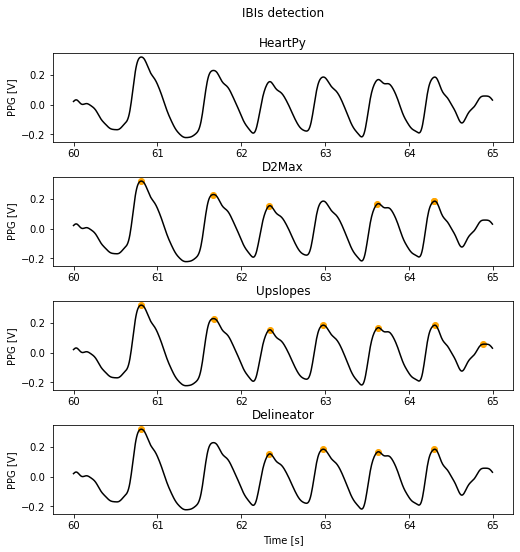

In [22]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, sharex = False, sharey = False, figsize = (8,8))
fig.suptitle('IBIs detection') 

t = np.arange(start_seconds,(start_seconds + no_seconds_to_load),1.0/fs)

ax1.plot(t, ppg_filt, color = 'black')
#ax1.scatter(t[0] + ibis_heartpy/fs, ppg_filt[ibis_heartpy], color = 'orange', marker = 'o')
ax1.set_ylabel('PPG [V]')
ax1.set_title('HeartPy')

ax2.plot(t, ppg_filt, color = 'black')
ax2.scatter(t[0] + ibis_d2max/fs, ppg_filt[ibis_d2max], color = 'orange', marker = 'o')
ax2.set_ylabel('PPG [V]')
ax2.set_title('D2Max')

ax3.plot(t, ppg_filt, color = 'black')
ax3.scatter(t[0] + ibis_upslopes/fs, ppg_filt[ibis_upslopes], color = 'orange', marker = 'o')
ax3.set_ylabel('PPG [V]')
ax3.set_title('Upslopes')

ax4.plot(t, ppg_filt, color = 'black')
ax4.scatter(t[0] + ibis_delineator/fs, ppg_filt[ibis_delineator], color = 'orange', marker = 'o')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('PPG [V]')
ax4.set_title('Delineator')

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.4, 
                    hspace = 0.4)

- We'll use the beats detected by the 'Upslopes' beat detector

In [48]:
ibis = ibis_upslopes

## Identify fiducial points on pulse waves

- Define the required functions

In [46]:
def fiducial_points(x,pks,fs,vis):
    """
    Description: Pulse detection and correction from pulsatile signals
    Inputs:  x, array with pulsatile signal [user defined units]
             pks, array with the position of the peaks [number of samples]
             fs, sampling rate of signal [Hz]
             vis, visualisation option [True, False]
    Outputs: fidp, dictionary with the positions of several fiducial points for the cardiac cycles [number of samples]
    
    Fiducial points:  1: Systolic peak (pks)
                      2: Onset, as the minimum before the systolic peak (ons)
                      3: Onset, using the tangent intersection method (ti) 
                      4: Diastolic peak (dpk)
                      5: Maximum slope (m1d)
                      6: a point from second derivative PPG (a2d)
                      7: b point from second derivative PPG (b2d)
                      8: c point from second derivative PPG (c2d)
                      9: d point from second derivative PPG (d2d)
                      10: e point from second derivative PPG (e2d)
                      11: p1 from the third derivative PPG (p1)    
                      12: p2 from the third derivative PPG (p2)
    
    Libraries: NumPy (as np), SciPy (Signal, as sp), Matplotlib (PyPlot, as plt)
    
    Version: 1.0 - June 2022
    
    Developed by: Elisa Mejía-Mejía
                   City, University of London
    
    """    
    # First, second and third derivatives
    d1x = sp.savgol_filter(x, 9, 5, deriv = 1) 
    d2x = sp.savgol_filter(x, 9, 5, deriv = 2) 
    d3x = sp.savgol_filter(x, 9, 5, deriv = 3) 
    
    #plt.figure()
    #plt.plot(x/np.max(x))
    #plt.plot(d1x/np.max(d1x))
    #plt.plot(d2x/np.max(d2x))
    #plt.plot(d3x/np.max(d3x))
    
    # Search in time series: Onsets between consecutive peaks
    ons = np.empty(0)
    for i in range(len(pks) - 1):
        start = pks[i]
        stop = pks[i + 1]
        ibi = x[start:stop]
        #plt.figure()
        #plt.plot(ibi, color = 'black')
        aux_ons, = np.where(ibi == np.min(ibi))
        ind_ons = aux_ons.astype(int)
        ons = np.append(ons, ind_ons + start)   
        #plt.plot(ind_ons, ibi[ind_ons], marker = 'o', color = 'red') 
    ons = ons.astype(int)
    #print('Onsets: ' + str(ons))
    #plt.figure()
    #plt.plot(x, color = 'black')
    #plt.scatter(pks, x[pks], marker = 'o', color = 'red') 
    #plt.scatter(ons, x[ons], marker = 'o', color = 'blue') 
    
    # Search in time series: Diastolic peak and dicrotic notch between consecutive onsets
    dia = np.empty(0)
    dic = np.empty(0)
    for i in range(len(ons) - 1):
        start = ons[i]
        stop = ons[i + 1]
        ind_pks, = np.intersect1d(np.where(pks < stop), np.where(pks > start))
        ind_pks = pks[ind_pks]
        ibi_portion = x[ind_pks:stop]
        ibi_2d_portion = d2x[ind_pks:stop]
        #plt.figure()
        #plt.plot(ibi_portion/np.max(ibi_portion))
        #plt.plot(ibi_2d_portion/np.max(ibi_2d_portion))
        aux_dic, _ = sp.find_peaks(ibi_2d_portion)
        aux_dic = aux_dic.astype(int)
        aux_dia, _ = sp.find_peaks(-ibi_2d_portion)
        aux_dia = aux_dia.astype(int)   
        if len(aux_dic) != 0:
            ind_max, = np.where(ibi_2d_portion[aux_dic] == np.max(ibi_2d_portion[aux_dic]))
            aux_dic_max = aux_dic[ind_max]
            if len(aux_dia) != 0:
                nearest = aux_dia - aux_dic_max
                aux_dic = aux_dic_max
                dic = np.append(dic, (aux_dic + ind_pks).astype(int))
                #plt.scatter(aux_dic, ibi_portion[aux_dic]/np.max(ibi_portion), marker = 'o')
                ind_dia, = np.where(nearest > 0)
                aux_dia = aux_dia[ind_dia]
                nearest = nearest[ind_dia]
                if len(nearest) != 0:
                    ind_nearest, = np.where(nearest == np.min(nearest))
                    aux_dia = aux_dia[ind_nearest]
                    dia = np.append(dia, (aux_dia + ind_pks).astype(int))
                    #plt.scatter(aux_dia, ibi_portion[aux_dia]/np.max(ibi_portion), marker = 'o')
                    #break
            else:
                dic = np.append(dic, (aux_dic_max + ind_pks).astype(int))
                #plt.scatter(aux_dia, ibi_portion[aux_dia]/np.max(ibi_portion), marker = 'o')     
    dia = dia.astype(int)
    dic = dic.astype(int)
    #plt.scatter(dia, x[dia], marker = 'o', color = 'orange')
    #plt.scatter(dic, x[dic], marker = 'o', color = 'green')
    
    # Search in D1: Maximum slope point
    m1d = np.empty(0)
    for i in range(len(ons) - 1):
        start = ons[i]
        stop = ons[i + 1]
        ind_pks, = np.intersect1d(np.where(pks < stop), np.where(pks > start))
        ind_pks = pks[ind_pks]
        ibi_portion = x[start:ind_pks]
        ibi_1d_portion = d1x[start:ind_pks]
        #plt.figure()
        #plt.plot(ibi_portion/np.max(ibi_portion))
        #plt.plot(ibi_1d_portion/np.max(ibi_1d_portion))
        aux_m1d, _ = sp.find_peaks(ibi_1d_portion)
        aux_m1d = aux_m1d.astype(int)  
        if len(aux_m1d) != 0:
            ind_max, = np.where(ibi_1d_portion[aux_m1d] == np.max(ibi_1d_portion[aux_m1d]))
            aux_m1d_max = aux_m1d[ind_max]
            if len(aux_m1d_max) > 1:
                aux_m1d_max = aux_m1d_max[0]
            m1d = np.append(m1d, (aux_m1d_max + start).astype(int))
            #plt.scatter(aux_m1d, ibi_portion[aux_dic]/np.max(ibi_portion), marker = 'o')
            #break    
    m1d = m1d.astype(int)
    #plt.scatter(m1d, x[m1d], marker = 'o', color = 'purple')
    
    # Search in time series: Tangent intersection points
    tip = np.empty(0)
    for i in range(len(ons) - 1):
        start = ons[i]
        stop = ons[i + 1]
        ibi_portion = x[start:stop]
        ibi_1d_portion = d1x[start:stop]
        ind_m1d, = np.intersect1d(np.where(m1d < stop), np.where(m1d > start))
        ind_m1d = m1d[ind_m1d] - start
        #plt.figure()
        #plt.plot(ibi_portion/np.max(ibi_portion))
        #plt.plot(ibi_1d_portion/np.max(ibi_1d_portion))
        #plt.scatter(ind_m1d, ibi_portion[ind_m1d]/np.max(ibi_portion), marker = 'o')
        #plt.scatter(ind_m1d, ibi_1d_portion[ind_m1d]/np.max(ibi_1d_portion), marker = 'o')
        aux_tip = np.round(((ibi_portion[0] - ibi_portion[ind_m1d])/ibi_1d_portion[ind_m1d]) + ind_m1d)
        aux_tip = aux_tip.astype(int)
        tip = np.append(tip, (aux_tip + start).astype(int))        
        #plt.scatter(aux_tip, ibi_portion[aux_tip]/np.max(ibi_portion), marker = 'o')
        #break
    tip = tip.astype(int)
    #plt.scatter(tip, x[tip], marker = 'o', color = 'aqua')
    
    # Search in D2: A, B, C, D and E points
    a2d = np.empty(0)
    b2d = np.empty(0)
    c2d = np.empty(0)
    d2d = np.empty(0)
    e2d = np.empty(0)
    for i in range(len(ons) - 1):
        start = ons[i]
        stop = ons[i + 1]
        ibi_portion = x[start:stop]
        ibi_1d_portion = d1x[start:stop]
        ibi_2d_portion = d2x[start:stop]
        ind_m1d = np.intersect1d(np.where(m1d > start),np.where(m1d < stop))
        ind_m1d = m1d[ind_m1d]
        #plt.figure()
        #plt.plot(ibi_portion/np.max(ibi_portion))
        #plt.plot(ibi_1d_portion/np.max(ibi_1d_portion))
        #plt.plot(ibi_2d_portion/np.max(ibi_2d_portion))
        aux_m2d_pks, _ = sp.find_peaks(ibi_2d_portion)
        aux_m2d_ons, _ = sp.find_peaks(-ibi_2d_portion)
        # a point:
        ind_a, = np.where(ibi_2d_portion[aux_m2d_pks] == np.max(ibi_2d_portion[aux_m2d_pks]))
        ind_a = aux_m2d_pks[ind_a]
        if (ind_a < ind_m1d):
            a2d = np.append(a2d, ind_a + start)
            #plt.scatter(ind_a, ibi_2d_portion[ind_a]/np.max(ibi_2d_portion), marker = 'o')
            # b point:
            ind_b = np.where(ibi_2d_portion[aux_m2d_ons] == np.min(ibi_2d_portion[aux_m2d_ons]))
            ind_b = aux_m2d_ons[ind_b]
            if (ind_b > ind_a) and (ind_b < len(ibi_2d_portion)):
                b2d = np.append(b2d, ind_b + start)
                #plt.scatter(ind_b, ibi_2d_portion[ind_b]/np.max(ibi_2d_portion), marker = 'o')
        # e point:
        ind_e, = np.where(aux_m2d_pks > ind_m1d - start)
        aux_m2d_pks = aux_m2d_pks[ind_e]
        ind_e, = np.where(aux_m2d_pks < 0.6*len(ibi_2d_portion))
        ind_e = aux_m2d_pks[ind_e]
        if len(ind_e) >= 1:
            if len(ind_e) >= 2:
                ind_e = ind_e[1]
            e2d = np.append(e2d, ind_e + start)
            #plt.scatter(ind_e, ibi_2d_portion[ind_e]/np.max(ibi_2d_portion), marker = 'o')
            # c point:
            ind_c, = np.where(aux_m2d_pks < ind_e)
            if len(ind_c) != 0:
                ind_c_aux = aux_m2d_pks[ind_c]
                ind_c, = np.where(ibi_2d_portion[ind_c_aux] == np.max(ibi_2d_portion[ind_c_aux]))
                ind_c = ind_c_aux[ind_c]
                if len(ind_c) != 0:
                    c2d = np.append(c2d, ind_c + start)
                    #plt.scatter(ind_c, ibi_2d_portion[ind_c]/np.max(ibi_2d_portion), marker = 'o')
            else:
                aux_m1d_ons, _ = sp.find_peaks(-ibi_1d_portion)
                ind_c, = np.where(aux_m1d_ons < ind_e)
                ind_c_aux = aux_m1d_ons[ind_c]
                if len(ind_c) != 0:
                    ind_c, = np.where(ind_c_aux > ind_b)
                    ind_c = ind_c_aux[ind_c]
                    if len(ind_c) > 1:
                        ind_c = ind_c[0]
                    c2d = np.append(c2d, ind_c + start)
                    #plt.scatter(ind_c, ibi_2d_portion[ind_c]/np.max(ibi_2d_portion), marker = 'o')
            # d point:
            if len(ind_c) != 0:
                ind_d = np.intersect1d(np.where(aux_m2d_ons < ind_e), np.where(aux_m2d_ons > ind_c))
                if len(ind_d) != 0:
                    ind_d_aux = aux_m2d_ons[ind_d]
                    ind_d, = np.where(ibi_2d_portion[ind_d_aux] == np.min(ibi_2d_portion[ind_d_aux]))
                    ind_d = ind_d_aux[ind_d]
                    if len(ind_d) != 0:
                        d2d = np.append(d2d, ind_d + start)
                        #plt.scatter(ind_d, ibi_2d_portion[ind_d]/np.max(ibi_2d_portion), marker = 'o')                
                else:
                    ind_d = ind_c
                    d2d = np.append(d2d, ind_d + start)
                    #plt.scatter(ind_d, ibi_2d_portion[ind_d]/np.max(ibi_2d_portion), marker = 'o')
    a2d = a2d.astype(int)
    b2d = b2d.astype(int)
    c2d = c2d.astype(int)
    d2d = d2d.astype(int)
    e2d = e2d.astype(int)
    #plt.figure()
    #plt.plot(d2x, color = 'black')
    #plt.scatter(a2d, d2x[a2d], marker = 'o', color = 'red') 
    #plt.scatter(b2d, d2x[b2d], marker = 'o', color = 'blue')
    #plt.scatter(c2d, d2x[c2d], marker = 'o', color = 'green')
    #plt.scatter(d2d, d2x[d2d], marker = 'o', color = 'orange')
    #plt.scatter(e2d, d2x[e2d], marker = 'o', color = 'purple')
    
    # Search in D3: P1 and P2 points
    p1p = np.empty(0)
    p2p = np.empty(0)
    for i in range(len(ons) - 1):
        start = ons[i]
        stop = ons[i + 1]
        ibi_portion = x[start:stop]
        ibi_1d_portion = d1x[start:stop]
        ibi_2d_portion = d2x[start:stop]
        ibi_3d_portion = d3x[start:stop]
        ind_b = np.intersect1d(np.where(b2d > start),np.where(b2d < stop))
        ind_b = b2d[ind_b]
        ind_c = np.intersect1d(np.where(c2d > start),np.where(c2d < stop))
        ind_c = c2d[ind_c]
        ind_d = np.intersect1d(np.where(d2d > start),np.where(d2d < stop))
        ind_d = d2d[ind_d]
        ind_dic = np.intersect1d(np.where(dic > start),np.where(dic < stop))
        ind_dic = dic[ind_dic]
        #plt.figure()
        #plt.plot(ibi_portion/np.max(ibi_portion))
        #plt.plot(ibi_1d_portion/np.max(ibi_1d_portion))
        #plt.plot(ibi_2d_portion/np.max(ibi_2d_portion))
        #plt.plot(ibi_3d_portion/np.max(ibi_3d_portion))
        #plt.scatter(ind_b - start, ibi_3d_portion[ind_b - start]/np.max(ibi_3d_portion), marker = 'o')
        #plt.scatter(ind_c - start, ibi_3d_portion[ind_c - start]/np.max(ibi_3d_portion), marker = 'o')
        #plt.scatter(ind_d - start, ibi_3d_portion[ind_d - start]/np.max(ibi_3d_portion), marker = 'o')
        #plt.scatter(ind_dic - start, ibi_3d_portion[ind_dic - start]/np.max(ibi_3d_portion), marker = 'o')
        aux_p3d_pks, _ = sp.find_peaks(ibi_3d_portion)
        aux_p3d_ons, _ = sp.find_peaks(-ibi_3d_portion)
        # P1:
        if (len(aux_p3d_pks) != 0 and len(ind_b) != 0):
            ind_p1, = np.where(aux_p3d_pks > ind_b - start)
            if len(ind_p1) != 0:
                ind_p1 = aux_p3d_pks[ind_p1[0]]
                p1p = np.append(p1p, ind_p1 + start)
                #plt.scatter(ind_p1, ibi_3d_portion[ind_p1]/np.max(ibi_3d_portion), marker = 'o')
        # P2:
        if (len(aux_p3d_ons) != 0 and len(ind_c) != 0 and len(ind_d) != 0):
            if ind_c == ind_d:
                ind_p2, = np.where(aux_p3d_ons > ind_d - start)
                ind_p2 = aux_p3d_ons[ind_p2[0]]
            else:
                ind_p2, = np.where(aux_p3d_ons < ind_d - start)
                ind_p2 = aux_p3d_ons[ind_p2[-1]]
            if len(ind_dic) != 0:
                aux_x_pks, _ = sp.find_peaks(ibi_portion)
                if ind_p2 > ind_dic - start:
                    ind_between = np.intersect1d(np.where(aux_x_pks < ind_p2), np.where(aux_x_pks > ind_dic - start))
                else:
                    ind_between = np.intersect1d(np.where(aux_x_pks > ind_p2), np.where(aux_x_pks < ind_dic - start))
                if len(ind_between) != 0:
                    ind_p2 = aux_x_pks[ind_between[0]]
            p2p = np.append(p2p, ind_p2 + start)
            #plt.scatter(ind_p2, ibi_3d_portion[ind_p2]/np.max(ibi_3d_portion), marker = 'o')
    p1p = p1p.astype(int)
    p2p = p2p.astype(int)
    #plt.figure()
    #plt.plot(d3x, color = 'black')
    #plt.scatter(p1p, d3x[p1p], marker = 'o', color = 'green') 
    #plt.scatter(p2p, d3x[p2p], marker = 'o', color = 'orange')
        
    if vis == True:
        fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, sharex = True, sharey = False, figsize=(10,10))
        fig.suptitle('Fiducial points') 

        ax1.plot(x, color = 'black')
        ax1.scatter(pks, x[pks.astype(int)], color = 'orange', label = 'pks')
        ax1.scatter(ons, x[ons.astype(int)], color = 'green', label = 'ons')
        ax1.scatter(dia, x[dia.astype(int)], color = 'yellow', label = 'dia')
        ax1.scatter(dic, x[dic.astype(int)], color = 'blue', label = 'dic')
        ax1.scatter(tip, x[tip.astype(int)], color = 'purple', label = 'dic')
        ax1.legend()
        ax1.set_ylabel('x')

        ax2.plot(d1x, color = 'black')
        ax2.scatter(m1d, d1x[m1d.astype(int)], color = 'orange', label = 'm1d')
        ax2.legend()
        ax2.set_ylabel('d1x')

        ax3.plot(d2x, color = 'black')
        ax3.scatter(a2d, d2x[a2d.astype(int)], color = 'orange', label = 'a')
        ax3.scatter(b2d, d2x[b2d.astype(int)], color = 'green', label = 'b')
        ax3.scatter(c2d, d2x[c2d.astype(int)], color = 'yellow', label = 'c')
        ax3.scatter(d2d, d2x[d2d.astype(int)], color = 'blue', label = 'd')
        ax3.scatter(e2d, d2x[e2d.astype(int)], color = 'purple', label = 'e')
        ax3.legend()
        ax3.set_ylabel('d2x')

        ax4.plot(d3x, color = 'black')
        ax4.scatter(p1p, d3x[p1p.astype(int)], color = 'orange', label = 'p1')
        ax4.scatter(p2p, d3x[p2p.astype(int)], color = 'green', label = 'p2')
        ax4.legend()
        ax4.set_ylabel('d3x')

        plt.subplots_adjust(left = 0.1,
                            bottom = 0.1, 
                            right = 0.9, 
                            top = 0.9, 
                            wspace = 0.4, 
                            hspace = 0.4)
        
    # Creation of dictionary
    fidp = {'pks': pks.astype(int),
            'ons': ons.astype(int),
            'tip': tip.astype(int),
            'dia': dia.astype(int),
            'dic': dic.astype(int),
            'm1d': m1d.astype(int),
            'a2d': a2d.astype(int),
            'b2d': b2d.astype(int),
            'c2d': c2d.astype(int),
            'd2d': d2d.astype(int),
            'e2d': e2d.astype(int),
            'p1p': p1p.astype(int),
            'p2p': p2p.astype(int)
            }
    return fidp

- Identify and visualise fiducial points

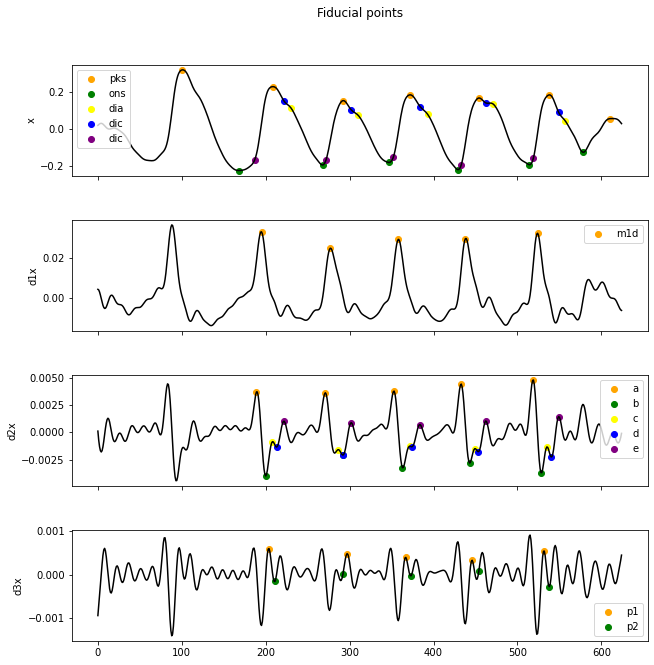

In [49]:
fidp = fiducial_points(ppg_filt,ibis,fs,vis = True)